In [6]:
import os
import sys
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Load configuration
from src.config import get_config
config = get_config()

print("✓ Configuration loaded successfully")
print(f"  Model classes: {config.model['n_classes']}")
print(f"  Training epochs: {config.training['n_epochs']}")
print(f"  Batch size: {config.training['batch_size']}")
print(f"  Learning rate: {config.training['learning_rate']}")

In [8]:
# Import our modules
from src.models.multibranch import MultiBranchModel
from src.models.earlystop import EarlyStopping
from src.models.trainer import train_epoch, validate
from src.data.dataset import load_large_dataset
from src.data.dataset import CustomTensorDataset

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load datasets using configuration paths
processed_dir = os.path.join(project_root, config.paths['processed'])
train_data_dict = load_large_dataset(os.path.join(processed_dir, 'train'), name="train_dataset")
val_data_dict = load_large_dataset(os.path.join(processed_dir, 'val'), name="val_dataset")

In [11]:
# Wrap in CustomTensorDataset
train_data = CustomTensorDataset(train_data_dict)
val_data = CustomTensorDataset(val_data_dict)

In [ ]:
# Create DataLoaders with batch size from configuration
batch_size = config.training['batch_size']
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
print(f"Using batch size: {batch_size}")

In [13]:
# Verify dataset sizes
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Verify data loading with updated dimensions
print("\nVerifying data loading...")
for batch in train_loader:
    print("\nBatch shapes:")
    print(f"Corrected: {batch['corrected'].shape}")       # Should be [batch_size, 1, 240, 320]
    print(f"Edge: {batch['edge'].shape}")                 # Should be [batch_size, 1, 240, 320]
    print(f"Thresholds: {batch['thresholds'].shape}")     # Should be [batch_size, 4, 240, 320]
    print(f"Labels: {batch['label'].shape}")              # Should be [batch_size]
    break

Training samples: 8448
Validation samples: 2112

Verifying data loading...

Batch shapes:
Corrected: torch.Size([250, 1, 240, 320])
Edge: torch.Size([250, 1, 240, 320])
Thresholds: torch.Size([250, 4, 240, 320])
Labels: torch.Size([250])


In [14]:
# Verify tensor types
print("\nVerifying tensor types...")
for batch in train_loader:
    print("\nBatch dtypes:")
    print(f"Corrected: {batch['corrected'].dtype}")
    print(f"Edge: {batch['edge'].dtype}")
    print(f"Thresholds: {batch['thresholds'].dtype}")
    print(f"Labels: {batch['label'].dtype}")
    break


Verifying tensor types...

Batch dtypes:
Corrected: torch.float32
Edge: torch.float32
Thresholds: torch.uint8
Labels: torch.int64


In [ ]:
# Training setup with configuration parameters
n_classes = config.model['n_classes']
dropout_rate = config.model['dropout_rate']
model = MultiBranchModel(n_classes, dropout_rate=dropout_rate).to(device)

# Optimizer with config parameters
learning_rate = config.training['learning_rate']
weight_decay = config.training['weight_decay']
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler with config parameters
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=config.training['lr_scheduler_factor'], 
    patience=config.training['lr_scheduler_patience'], 
    verbose=True,  
    min_lr=config.training['lr_scheduler_min_lr']
)

# Early stopping with config parameters
early_stopping = EarlyStopping(
    patience=config.training['early_stopping_patience'], 
    min_delta=config.training['early_stopping_min_delta']
)

print(f"Model configured:")
print(f"  Classes: {n_classes}")
print(f"  Dropout: {dropout_rate}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")

In [ ]:
# Training loop with configuration
print("\nStarting training...")
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
n_epochs = config.training['n_epochs']

# Prepare model save path
models_dir = os.path.join(project_root, config.paths['models'])
os.makedirs(models_dir, exist_ok=True)
model_save_path = os.path.join(models_dir, 'best_model.pt')

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    
    # Train and validate
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, model_save_path)
        print(f"✓ Best model saved to {model_save_path}")
    
    # Check early stopping
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("\nTraining complete!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved to: {model_save_path}")

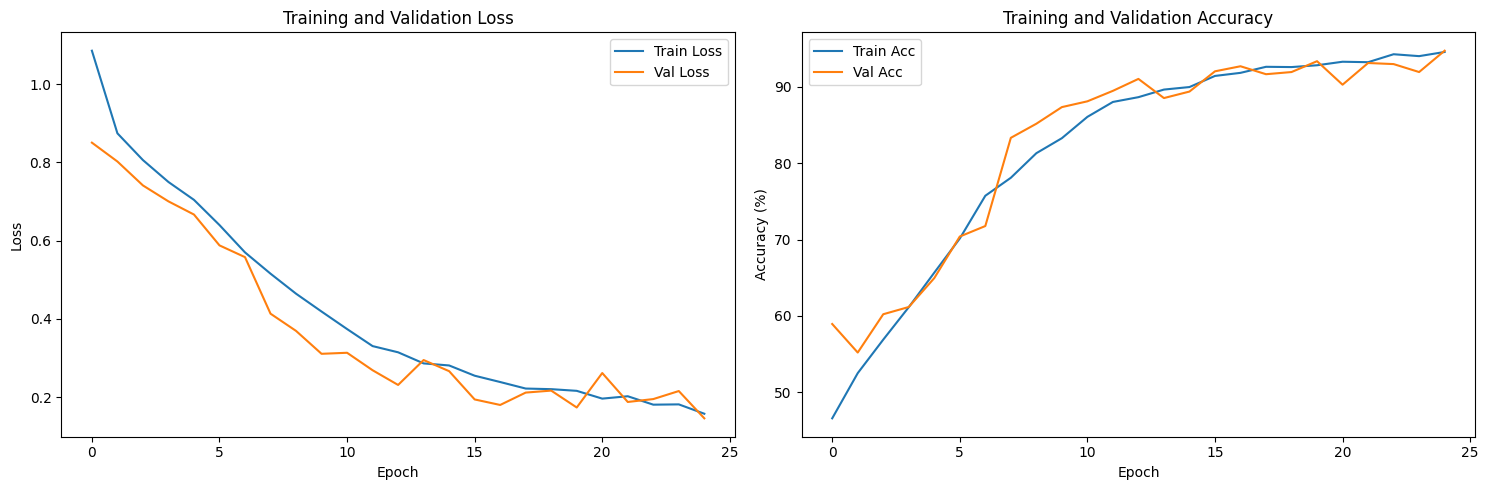

In [21]:
# Plot training history with learning rate
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# Define label mapping from configuration (with English translations)
label_mapping_display = {
    'No activity': config.labels['Despejado'],
    'Cloudy conditions': config.labels['Nublado'],
    'Emissions': config.labels['Emisiones'],
    'Lava flow': config.labels['Flujo']
}
class_names = list(label_mapping_display.keys())

print(f"Label mapping:")
for name, idx in label_mapping_display.items():
    print(f"  {name}: {idx}")

# Get predictions and true labels for the validation set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        corrected = batch['corrected'].float().to(device)
        edge = batch['edge'].float().to(device)
        thresholds = batch['thresholds'].float().to(device)
        labels = batch['label'].to(device)

        outputs = model(corrected, edge, thresholds)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize confusion matrix by row (true labels) to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=class_names)
disp.plot(cmap='OrRd', values_format=".2f", ax=ax)
plt.xlabel("Predicted Volcanic State")
plt.ylabel("Observed Volcanic State")
plt.tight_layout()
plt.show()

# Save confusion matrix to results directory
results_dir = os.path.join(project_root, config.paths['results'])
os.makedirs(results_dir, exist_ok=True)
plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
print(f"\n✓ Confusion matrix saved to {results_dir}/confusion_matrix.png")